# Figure 1: Literature data

The following code uses the main data source of the paper to analyze the literature recall by ranking the zeolite/OSDAs by the metric of interest (e.g., templating energy) and verifying if they agree or not with the literature.

In [1]:
import itertools
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from scipy import stats

LABEL_ALIAS = {
    'lit': 'In literature?',
    'ge': 'Germanosilicate composition?',
    'zeo': 'Zeolite composition?',
    'zty': 'Zeotype composition?',
}

df = pd.read_csv('../data/binding.csv', index_col=0)

/home/dskoda/.conda/envs/htvs/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We start the analysis by defining the function that gets us the recall curve (sorting + normalizing), and by grouping the data frame by the zeolite-OSDA pairs. The latter is useful if we have more than one pose per complex.

In [2]:
def get_recall(df_, metric, ascending=True):
    sdf = df_.sort_values(metric, ascending=ascending)
    s = sdf[LABEL_ALIAS['lit']].cumsum() / sdf[LABEL_ALIAS['lit']].sum()
    return s

def get_norm_auc(df_, metric):
    s = get_recall(df_, metric)
    best_case = get_recall(df_, LABEL_ALIAS['lit'], ascending=False)

    return s.mean() / best_case.mean()

In [3]:
idxmin = df.groupby(['Zeolite', 'InchiKey']).idxmin()

## Figure 1D

### Recall for zeolites

Here, we plot the left panel of Fig. 1D of the main paper, with the recall for a few zeolites.

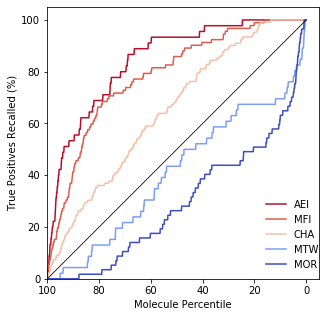

In [16]:
norm = mpl.colors.Normalize(vmin=0.3, vmax=0.85)
cmap = cm.coolwarm
metric = 'Templating'
to_plot = ['AEI', 'MFI', 'CHA', 'MTW', 'MOR']


fig, ax = plt.subplots(figsize=(5, 5))

all_recalls = []
for subst in to_plot:
    sdf = df.loc[idxmin.loc[subst, metric].values]
    recall = get_recall(sdf, 'Templating')
    x = np.linspace(0, 1, len(recall))
    
    auc = recall.mean()
    
    ax.plot(x, recall.values, label=subst, color=cmap(norm(auc)))
    
    recall_df = pd.DataFrame({
        "x": x,
        "recall": recall.values,
        "zeolite": subst,
    })
    
    all_recalls.append(recall_df)

ax.plot(x, x, color='black', linestyle='-', linewidth=0.8)   
    
ax.legend(ncol=1, frameon=False, fontsize='medium', loc='lower right', bbox_to_anchor=(1.03, 0.0))

ax.set_xlim(0, 1.05)
ax.set_ylim(0, 1.05)
ax.set_aspect('equal')

xticks = np.linspace(0, 1, 6)
ax.set_xticks(xticks)
ax.set_xticklabels(["%d" % t for t in reversed(xticks * 100)])

ax.set_yticks(xticks)
ax.set_yticklabels(["%d" % t for t in (xticks * 100)])

ax.set_xlabel('Molecule Percentile')
ax.set_ylabel('True Positives Recalled (%)')

plt.show()

# Export the tabulated data
all_recalls = pd.concat(all_recalls)
all_recalls.to_csv('../data/fig1/fig1D_left.csv')

### Recall for OSDAs

Here, we plot the right panel of Fig. 1D, showing the recall curve for a few OSDAs.

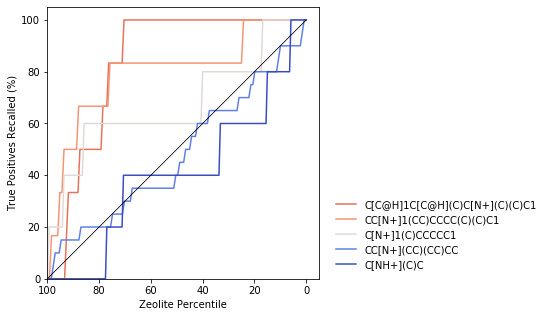

In [17]:
norm = mpl.colors.Normalize(vmin=0.42, vmax=0.91)
cmap = cm.coolwarm
metric = 'Templating'
to_plot = {
    'C[C@H]1C[C@H](C)C[N+](C)(C)C1': 'HGACHMQVWWZPCX-IUCAKERBNA-N',
    'CC[N+]1(CC)CCCC(C)(C)C1': 'IGTGDQUMHRHPHY-UHFFFAOYNA-N',
    'C[N+]1(C)CCCCC1': 'NNCAWEWCFVZOGF-UHFFFAOYNA-N',
    'CC[N+](CC)(CC)CC': 'CBXCPBUEXACCNR-UHFFFAOYNA-N',
    'C[NH+](C)C': 'GETQZCLCWQTVFV-ATZLMRTINA-O',
}

fig, ax = plt.subplots(figsize=(5, 5))

all_recalls = []
for i, (smi, lig) in enumerate(to_plot.items()):
    sdf = df.loc[idxmin.swaplevel().loc[lig, metric]].sort_values(metric, ascending=True).fillna(0)
    
    recall = get_recall(sdf, 'Templating')
    x = np.linspace(0, 1, len(recall))
    
    auc = recall.mean()
    
    ax.plot(x, recall.values, label=smi, color=cmap(norm(auc)))
    
    recall_df = pd.DataFrame({
        "x": x,
        "recall": recall.values,
        "zeolite": subst,
    })
    
    all_recalls.append(recall_df)

ax.plot(x, x, color='black', linestyle='-', linewidth=0.8)   
    
ax.legend(ncol=1, frameon=False, fontsize='medium', loc='lower left', bbox_to_anchor=(1.03, 0.0))

ax.set_xlim(0, 1.05)
ax.set_ylim(0, 1.05)
ax.set_aspect('equal')

xticks = np.linspace(0, 1, 6)
ax.set_xticks(xticks)
ax.set_xticklabels(["%d" % t for t in reversed(xticks * 100)])

ax.set_yticks(xticks)
ax.set_yticklabels(["%d" % t for t in (xticks * 100)])

ax.set_xlabel('Zeolite Percentile')
ax.set_ylabel('True Positives Recalled (%)')

plt.show()

all_recalls = pd.concat(all_recalls)
all_recalls.to_csv('../data/fig1/fig1D_right.csv')

## Analyzing all AUCs

To plot Fig. 1E and 1F, we have to analyze the recall curves for all zeolites, then select only the frameworks with at least 10 true positive data points (or OSDAs with at least 6 positive points), as reported in the Methods.

In [18]:
METRICS = [
    'Binding (SiO2)',
    'Binding (OSDA)',
    'Competition (SiO2)',
    'Competition (OSDA)',
    'Templating',
]

def get_all_substrate_rocs(df, substrate, idxmin=idxmin, metrics=METRICS):
    roc = {}
    for metric in metrics:
        df_ = df.reindex(idxmin.loc[substrate, metric].values).sort_values(metric, ascending=True)
        roc[metric] = get_norm_auc(df_, metric)
    
    roc['num_positive'] = df.reindex(idxmin.loc[substrate, 'Binding (SiO2)'].values)[LABEL_ALIAS['lit']].sum()
    
    return roc

def get_all_ligand_rocs(df, ligand, idxmin=idxmin, metrics=METRICS):    
    roc = {}
    for metric in metrics:
        df_ = df.reindex(idxmin.swaplevel().loc[ligand, metric].values).sort_values(metric, ascending=True)
        roc[metric] = get_norm_auc(df_, metric)
    
    roc['num_positive'] = df.reindex(idxmin.swaplevel().loc[ligand, 'Binding (SiO2)'].values)[LABEL_ALIAS['lit']].sum()
    
    return roc

boxplot_kwargs = {
    'widths': 0.5,
    'patch_artist': True,
    'medianprops': {
        'color': 'black'
    }
}

NUM_POSITIVE_ZEO = 10
NUM_POSITIVE_SDA = 6

Calculating the curves for the zeolites and OSDAs:

In [19]:
allrocs = []
for framework in sorted(df['Zeolite'].unique()):
    roc = get_all_substrate_rocs(df, framework, idxmin)
    roc['Zeolite'] = framework
    allrocs.append(roc)

subrocs = pd.DataFrame(allrocs).set_index('Zeolite').dropna()
subrocs = subrocs.loc[subrocs.num_positive > NUM_POSITIVE_ZEO]

In [20]:
ligrocs = []

for lig in sorted(df['InchiKey'].unique()):
    roc = get_all_ligand_rocs(df, lig, idxmin)
    roc['InchiKey'] = lig
    ligrocs.append(roc)

ligrocs = pd.DataFrame(ligrocs).set_index('InchiKey').dropna()
ligrocs = ligrocs.loc[ligrocs.num_positive > NUM_POSITIVE_SDA]

Calculating the improvement with respect to the templating energy:

In [21]:
METRIC_INTEREST = 'Templating'

lig_improv = (ligrocs[METRIC_INTEREST].values.reshape(-1, 1) - ligrocs).drop(['num_positive', METRIC_INTEREST], axis=1)
sub_improv = (subrocs[METRIC_INTEREST].values.reshape(-1, 1) - subrocs).drop(['num_positive', METRIC_INTEREST], axis=1)

In [22]:
ligstats = lig_improv.reset_index(drop=True).melt()
ligstats['group'] = 'OSDA'

substats = sub_improv.reset_index(drop=True).melt()
substats['group'] = 'Zeolite'

auc_stats = pd.concat([
    ligstats,
    substats,
], axis=0)

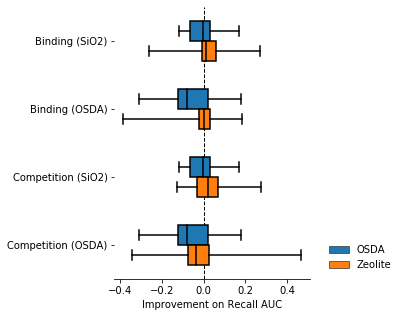

In [23]:
fig, ax = plt.subplots(figsize=(3.5, 5))

g = sns.boxplot(
    x="value",
    y="variable",
    hue="group",
    data=auc_stats,
    whis=[0, 100],
    width=.6,
    ax=ax,
    saturation=1.0,
)

for mybox in g.artists:
    mybox.set_edgecolor('k')

for line in g.lines:
    line.set_color('k')

ax.set(xlabel="Improvement on Recall AUC", ylabel="")
ax.legend(loc='lower left', bbox_to_anchor=(1.05, 0.0), frameon=False)

sns.despine(left=True)

yrange = ax.get_ylim()
ax.plot([0, 0], yrange, c='black', linewidth=1.0, linestyle='--', zorder=-1)
ax.set_ylim(yrange)

plt.show()

In [29]:
auc_stats.to_csv('../data/fig1/fig1F.csv')
subrocs.to_csv('../data/figS5/zeolites.csv')

## Getting recall curves for different compositions

Finally, we plot Fig. 1E, which shows the AUC for zeolites according to their composition.

In [30]:
compositions = [
    'Zeolite composition?',
    'Zeotype composition?',
    'Germanosilicate composition?',
]

composition_colors = {
    'Germanosilicate composition?': '#d62728',
    'Zeolite composition?': '#1f77b4',
    'Zeotype composition?': '#ff7f0e',
}

In [31]:
ztypedata = []
for subst in sorted(df['Zeolite'].unique()):
    for ztype in compositions:
        roc = {}
        for metric in METRICS:
            
            df_ = df.copy().reindex(idxmin.loc[subst, metric].values).sort_values(metric, ascending=True)
            df_.loc[np.logical_not(df_[ztype]), LABEL_ALIAS['lit']] = 0

            num_positive = df_[LABEL_ALIAS['lit']].sum()
            if num_positive > 2:
                roc[metric] = get_norm_auc(df_, metric)
                roc['num_positive'] = num_positive

        roc['substrate'] = subst
        roc['ztype'] = ztype
        ztypedata.append(roc)

In [32]:
ztyperocs = pd.DataFrame(ztypedata).dropna()
ztyperocs = ztyperocs.loc[ztyperocs.num_positive > 5]

pvt = ztyperocs.pivot(index='substrate', columns='ztype', values=METRIC_INTEREST).reset_index()
pvt['max'] = pvt.max(1)

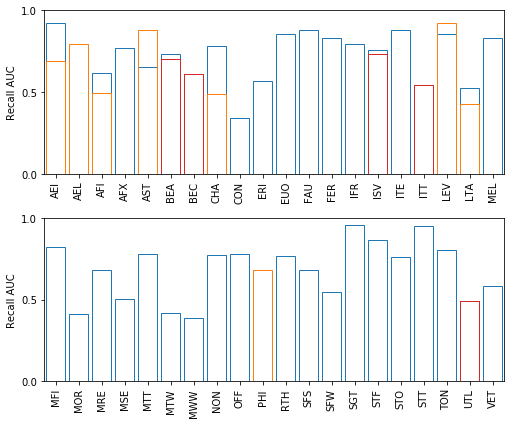

In [33]:
fig, ax_fig = plt.subplots(2, 1, figsize=(7.2, 6))

for ax, start, end in zip(ax_fig, [0, len(pvt) // 2], [len(pvt) // 2, len(pvt)]):
#     ax.spines['left'].set_visible(False)

    for y in compositions:
        sns.barplot(
            y=y,
            x="substrate",
            data=pvt.iloc[start:end],
            ax=ax,
            edgecolor=composition_colors[y],
            facecolor=(1, 1, 1, 0),
        )

    ax.set_ylabel("Recall AUC")
    ax.set_xlabel("")
    ax.set_ylim([0, 1])
    ax.set_yticks([0, 0.5, 1])

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.tight_layout()
plt.show()

In [35]:
pvt.to_csv('../data/fig1/fig1E.csv')

## AUCs for different binding metrics and frameworks

Finally, we reproduce Fig. S5 from the Supplementary Materials, which discloses the AUC values for different frameworks and metrics.

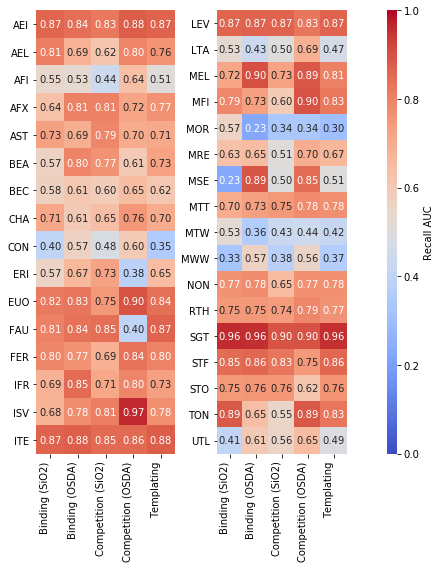

In [36]:
fig, (ax1, ax2, cax) = plt.subplots(1, 3, figsize=(6, 8), gridspec_kw={'width_ratios': (0.45, 0.45, 0.03)})

data = subrocs.drop(['num_positive'], axis=1)
norm = plt.Normalize(0, 1)
cmap = 'coolwarm'

sns.heatmap(
    data.iloc[:(len(data) // 2)],
    vmin=0,
    vmax=1,
    ax=ax1,
    square=True,
    cmap=cmap,
    cbar_ax=cax,
    cbar_kws={"orientation": "vertical"},
    annot=True,
    fmt='.2f'
)

sns.heatmap(
    data.iloc[(len(data) // 2):],
    vmin=0,
    vmax=1,
    ax=ax2,
    square=True,
    cmap=cmap,
    cbar_ax=cax,
    cbar_kws={"orientation": "vertical"},
    annot=True,
    fmt='.2f'
)

for ax in [ax1, ax2]:
    YLIM = ax.get_ylim()
    ax.set_ylim(YLIM[0] + 0.5, YLIM[1] - 0.5)
    ax.set_ylabel('')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

fig.tight_layout()

cax.set_ylabel('Recall AUC')

plt.show()